[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jsnowacki/slides/blob/master/2019/uw_knn/neuron_excitaility_model.ipynb)

<a href="https://colab.research.google.com/github/jsnowacki/slides/blob/master/2019/uw_knn/neuron_excitaility_model.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"></a>

# Neural excitability model

The below example is a set of experiments with model given in the paper: J Nowacki, HM Osinga, JT Brown, AD Randall, K Tsaneva-Atanasova _A unified model of CA1/3 pyramidal cells: an investigation into excitability_, Progress in biophysics and molecular biology 105 (1-2), 34-48, https://doi.org/10.1016/j.pbiomolbio.2010.09.020. 

First install some requirements:

In [0]:
!pip install numpy scipy matplotlib

In [0]:
import numpy as np
import scipy.integrate as spi
import matplotlib.pyplot as plt
from matplotlib import gridspec
from functools import partial
%matplotlib inline

plt.rcParams['figure.figsize'] = [10, 8]

A plain ol' sigmoid:

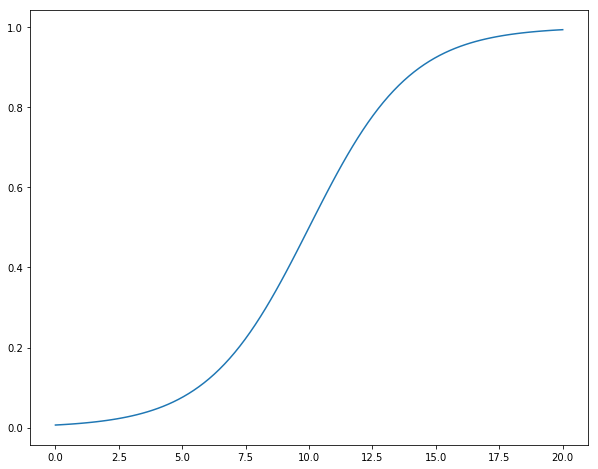

In [0]:
def x_inf(v, v_x, k_x):
  return 1/(1 + np.exp(-(v - v_x)/k_x, dtype=np.float128))

v = np.linspace(0, 20, 100)
plt.plot(v, x_inf(v, v_x=10, k_x=2));

The model with all the parameters. To change the parameter in simulation you can just change the variable value.

In [0]:
c_m = 1.0

# Inward currents
e_i = 80.0 

g_fi = 2.0; v_m_fi = -25.0; k_m_fi = 5.0

g_si = 0.5; v_m_si = -54.0; k_m_si = 5.0; t_m_si = 3.0 
v_h_si = -65.0; k_h_si = -8.5; t_h_si = 20.0 

# Ourward currents
e_o = -80.0 

g_fo = 9.5; v_m_fo = -6.0; k_m_fo = 11.5; t_m_fo = 1.0 

g_so = 1.2; v_m_so = -30.0; k_m_so = 10.0; t_m_so = 75.0 

m_fi_inf = partial(x_inf, v_x=v_m_fi, k_x=k_m_fi)
m_si_inf = partial(x_inf, v_x=v_m_si, k_x=k_m_si)
h_si_inf = partial(x_inf, v_x=v_h_si, k_x=k_h_si)
m_fo_inf = partial(x_inf, v_x=v_m_fo, k_x=k_m_fo)
m_so_inf = partial(x_inf, v_x=v_m_so, k_x=k_m_so)

i_app_t_min = 20; i_app_t_max = 23; i_app_a = 20

@np.vectorize
def i_app(t): return i_app_a if t >= i_app_t_min and t < i_app_t_max else 0

def model(t, y):
  v, m_si, m_fo, m_so, h_si = y
    
  i_fi = g_fi * m_fi_inf(v) * (v - e_i)
  i_si = g_si * np.power(m_si, 2) * h_si * (v - e_i)
  i_fo = g_fo * m_fo * (v - e_o)
  i_so = g_so * m_so * (v - e_o)
    
  dv = (-(i_fi + i_si + i_fo + i_so) + i_app(t))/c_m
  dm_si = (m_si_inf(v) - m_si) / t_m_si
  dm_fo = (m_fo_inf(v) - m_fo) / t_m_fo
  dm_so = (m_so_inf(v) - m_so) / t_m_so
  dh_si = (h_si_inf(v) - h_si) / t_h_si
  
  return np.array([dv, dm_si, dm_fo, dm_so, dh_si])

(In)axtivation functions:

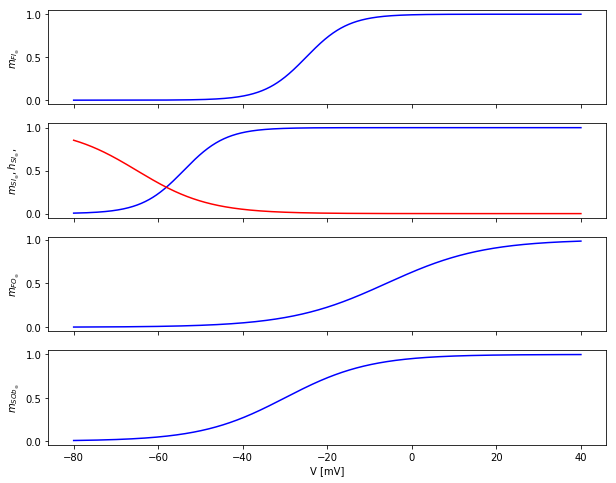

In [0]:
v = np.linspace(-80, 40, 1000)

ax = plt.subplot(4, 1, 1)
ax.plot(v, m_fi_inf(v), 'b-')
ax.set_xticklabels([])
ax.set_ylabel('$m_{FI_\infty}$')

ax = plt.subplot(4, 1, 2)
ax.plot(v, m_si_inf(v), 'b-')
ax.plot(v, h_si_inf(v), 'r-')
ax.set_xticklabels([])
ax.set_ylabel('$m_{SI_\infty}, h_{SI_\infty},$')

ax = plt.subplot(4, 1, 3)
ax.plot(v, m_fo_inf(v), 'b-')
ax.set_xticklabels([])
ax.set_ylabel('$m_{FO_\infty}$')

ax = plt.subplot(4, 1, 4)
ax.plot(v, m_so_inf(v), 'b-')
ax.set_ylabel('$m_{SOb_\infty}$')
ax.set_xlabel('V [mV]');

Model simulation for differet values of $g_{SI}$.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


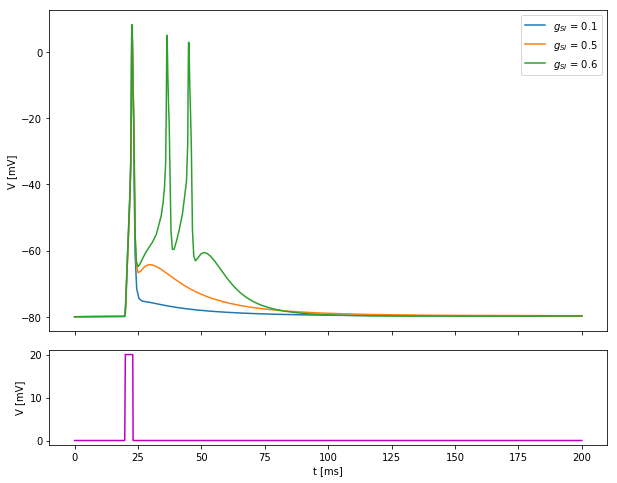

In [0]:
t_span = [0, 200]
v_0 = e_o
y_0 = [v_0, m_si_inf(v_0), m_fo_inf(v_0), m_so_inf(v_0), h_si_inf(v_0)]

gs = gridspec.GridSpec(4, 1)

# The voltageb
ax= plt.subplot(gs[:3, :])
leg = []
for val in [0.1, 0.5, 0.6]:
  g_si = val
  leg.append('$g_{{SI}}$ = {}'.format(g_si))
  
  # simulation
  sol = spi.solve_ivp(model, t_span, y_0, method='RK45', dense_output=True)
  
  # plto V vs t
  ax.plot(sol.t, sol.y[0,:])
  
ax.set_ylabel('V [mV]')
ax.set_xticklabels([])
ax.legend(leg)

# I_app current
ax = plt.subplot(plt.subplot(gs[3, :]))
ax.plot(sol.t, i_app(sol.t), 'm')
ax.set_xlabel('t [ms]')
ax.set_ylabel('V [mV]');

The other system variables:

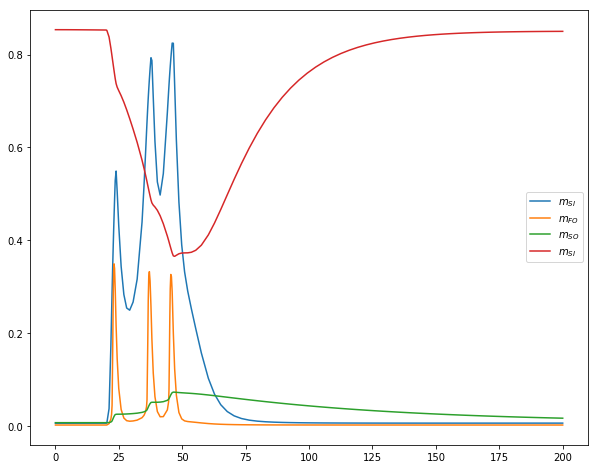

In [0]:
for i in range(1, sol.y.shape[0]):
  plt.plot(sol.t, sol.y[i,:])

plt.legend(['$m_{SI}$', '$m_{FO}$', '$m_{SO}$', '$m_{SI}$']);